In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ===== MIF Module =====
class MIFModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv288 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv144 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv72 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv36 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x288 = x
        x144 = F.interpolate(x, size=(144, 144), mode='bilinear', align_corners=True)
        x72 = F.interpolate(x, size=(72, 72), mode='bilinear', align_corners=True)
        x36 = F.interpolate(x, size=(36, 36), mode='bilinear', align_corners=True)

        s288 = self.conv288(x288)
        s144 = self.conv144(x144)
        s72 = self.conv72(x72)
        s36 = self.conv36(x36)

        return s288, s144, s72, s36
# ===== Res2Block + SEBlock =====
class Res2Block(nn.Module):
    def __init__(self, in_channels, out_channels, scale=4):
        super().__init__()
        assert in_channels % scale == 0
        self.scale = scale
        self.width = in_channels // scale

        self.conv1x1_in = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(self.width, self.width, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(self.width),
                nn.ReLU(inplace=True)
            ) for _ in range(scale - 1)
        ])

        self.conv1x1_out = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn_out = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1x1_in(x)
        splits = torch.split(out, self.width, dim=1)
        outputs = [splits[0]]

        for i in range(1, self.scale):
            if i == 1:
                y = self.convs[i - 1](splits[i])
            else:
                y = self.convs[i - 1](splits[i] + outputs[-1])
            outputs.append(y)

        out = torch.cat(outputs, dim=1)
        out = self.conv1x1_out(out)
        out = self.bn_out(out)
        out += identity
        return self.relu(out)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class Res2SEBlock(nn.Module):
    def __init__(self, channels, dropout=0.3):
        super().__init__()
        self.res2 = Res2Block(channels, channels)
        self.se = SEBlock(channels)
        self.dropout = nn.Dropout2d(dropout)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.res2(x)
        out = self.se(out)
        out = self.dropout(out)
        out = self.bn(out)
        out = self.relu(out)
        return out + identity
# ===== PDC Block =====
class PDCBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch2_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch2_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch3_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(inplace=True)
        )
        self.branch3_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch3_conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch4_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=8, dilation=8),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv4 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.fuse = nn.Conv2d(out_channels * 4, out_channels, kernel_size=1)

    def forward(self, x):
        b1 = self.branch1(x)

        b2 = self.branch2_conv2(self.branch2_conv1(x))

        b3_1 = self.branch3_conv1(x)
        b3_2 = self.branch3_conv2(b3_1)
        b3 = self.branch3_conv3(b3_1 + b3_2)

        b4_1 = self.branch4_conv1(x)
        b4_2 = self.branch4_conv2(b4_1)
        b4_3 = self.branch4_conv3(b4_2 + b4_1)
        b4 = self.branch4_conv4(b4_3 + b4_2 + b4_1)

        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.fuse(out)
# ===== Final MRP_UNet Model =====
class MRP_UNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.mif = MIFModule()

        # Main encoder
        self.enc1 = Res2SEBlock(64)
        self.enc2 = Res2SEBlock(128)
        self.enc3 = Res2SEBlock(256)
        self.enc4 = Res2SEBlock(512)

        # Side encoders (for MIF features)
        self.side_enc2 = Res2SEBlock(64)
        self.side_enc3 = Res2SEBlock(128)
        self.side_enc4 = Res2SEBlock(256)

        # Bottleneck
        self.bottleneck_pre = Res2SEBlock(512)
        self.pdc = PDCBlock(512, 512)
        self.bottleneck_post = Res2SEBlock(512)

        # Decoder
        self.dec4 = self.decoder_block(1024, 512, 256)
        self.dec3 = self.decoder_block(512, 256, 128)
        self.dec2 = self.decoder_block(256, 128, 64)
        self.dec1 = self.decoder_block(128, 64, 64)

        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def decoder_block(self, in_ch, mid_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):  # [B, 3, 288, 288]
        s288, s144, s72, s36 = self.mif(x)

        # Encoder
        e1 = self.enc1(s288)
        skip1 = e1
        x = F.max_pool2d(e1, 2)

        s144 = self.side_enc2(s144)
        x = torch.cat([x, s144], dim=1)
        e2 = self.enc2(x)
        skip2 = e2
        x = F.max_pool2d(e2, 2)

        s72 = self.side_enc3(s72)
        x = torch.cat([x, s72], dim=1)
        e3 = self.enc3(x)
        skip3 = e3
        x = F.max_pool2d(e3, 2)

        s36 = self.side_enc4(s36)
        x = torch.cat([x, s36], dim=1)
        e4 = self.enc4(x)
        skip4 = e4
        x = F.max_pool2d(e4, 2)

        # Bottleneck
        x = self.bottleneck_pre(x)
        x = self.pdc(x)
        x = self.bottleneck_post(x)

        # Decoder
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip4], dim=1)
        x = self.dec4(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip3], dim=1)
        x = self.dec3(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip2], dim=1)
        x = self.dec2(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip1], dim=1)
        x = self.dec1(x)

        return self.final(x)  # [B, num_classes, 288, 288]


# model details

In [ ]:
model = MRP_UNet(num_classes=2)
print(model)


MRP_UNet(
  (mif): MIFModule(
    (conv288): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv144): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv72): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv36): Sequential(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (enc1): Res2SEBlock(
    (res2): Res2Block(
      (conv1x1_in): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (conv1x1_out): Conv2d(64, 64, kernel_size=

In [ ]:
!pip install torchinfo


In [ ]:
from torchinfo import summary

summary(model, input_size=(1, 3, 288, 288))


Layer (type:depth-idx)                        Output Shape              Param #
MRP_UNet                                      [1, 2, 288, 288]          --
├─MIFModule: 1-1                              [1, 64, 288, 288]         --
│    └─Sequential: 2-1                        [1, 64, 288, 288]         --
│    │    └─Conv2d: 3-1                       [1, 64, 288, 288]         256
│    │    └─ReLU: 3-2                         [1, 64, 288, 288]         --
│    └─Sequential: 2-2                        [1, 64, 144, 144]         --
│    │    └─Conv2d: 3-3                       [1, 64, 144, 144]         256
│    │    └─ReLU: 3-4                         [1, 64, 144, 144]         --
│    └─Sequential: 2-3                        [1, 128, 72, 72]          --
│    │    └─Conv2d: 3-5                       [1, 128, 72, 72]          512
│    │    └─ReLU: 3-6                         [1, 128, 72, 72]          --
│    └─Sequential: 2-4                        [1, 256, 36, 36]          --
│    │    └─Conv2

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")


Total Parameters: 36246810
Trainable Parameters: 36246810


In [ ]:
!pip install torchview


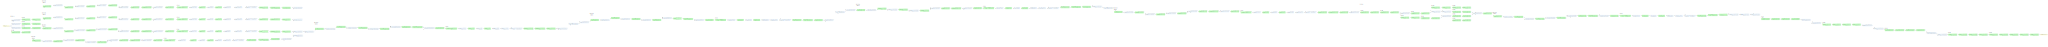

In [ ]:
from torchview import draw_graph


# Instantiate model
model = MRP_UNet(num_classes=2)

# Draw graph
viz = draw_graph(
    model,
    input_size=(1, 3, 288, 288),   # batch size 1, 3-channel image
    expand_nested=True,           # shows inner modules like Res2SEBlock
    graph_dir='LR',               # left-to-right layout
    save_graph=True,              # saves as .png
    filename='mrp_unet_architecture'  # output file name (default: 'model')
)

viz.visual_graph  # display in Jupyter Notebook or save as image


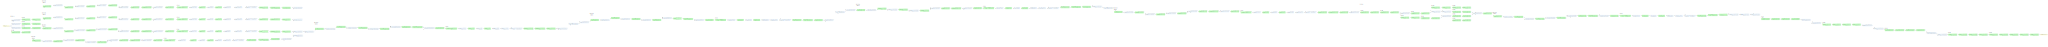

In [ ]:
from torchview import draw_graph


# Instantiate model
model = MRP_UNet(num_classes=2)

# Draw graph
viz = draw_graph(
    model,
    input_size=(1, 3, 288, 288),   # batch size 1, 3-channel image
    expand_nested=True,           # shows inner modules like Res2SEBlock
    graph_dir='LR',               # left-to-right layout
    save_graph=True,              # saves as .png
    filename='mrp_unet_architecture'  # output file name (default: 'model')
)

viz.visual_graph  # display in Jupyter Notebook or save as image


In [ ]:
from torchview import draw_graph


pdc = PDCBlock(in_channels=512, out_channels=512)

pdc_graph = draw_graph(
    pdc,
    input_size=(1, 512, 36, 36),
    expand_nested=True,
    save_graph=True,
    filename='pdc_block',
    directory='.',  # Save to current directory
    graph_dir='TB'  # Top to bottom layout (or use 'LR' for left-right)
)


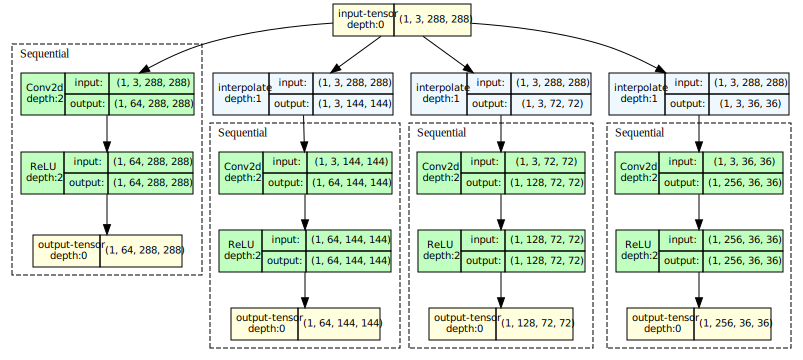

In [ ]:
mif = MIFModule()
mif_graph = draw_graph(mif, input_size=(1, 3, 288, 288), expand_nested=True)
mif_graph.visual_graph


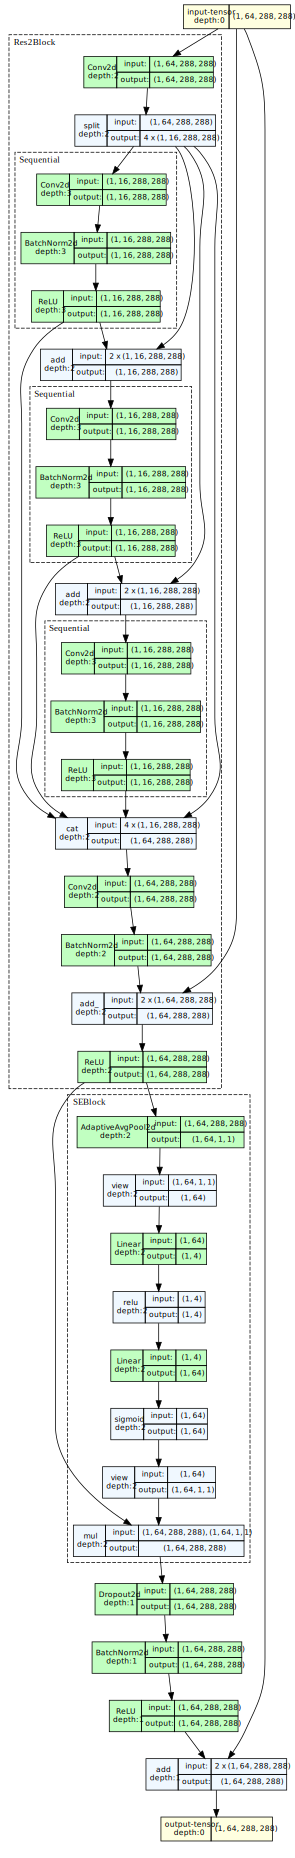

In [ ]:
res2se = Res2SEBlock(channels=64)
res2se_graph = draw_graph(res2se, input_size=(1, 64, 288, 288), expand_nested=True)
res2se_graph.visual_graph


In [ ]:


mif = MIFModule()
mif_graph = draw_graph(
    mif,
    input_size=(1, 3, 288, 288),
    expand_nested=True,
    save_graph=True,
    filename='mif_module',
    directory='.',  # Save to current directory
    graph_dir='TB'
)


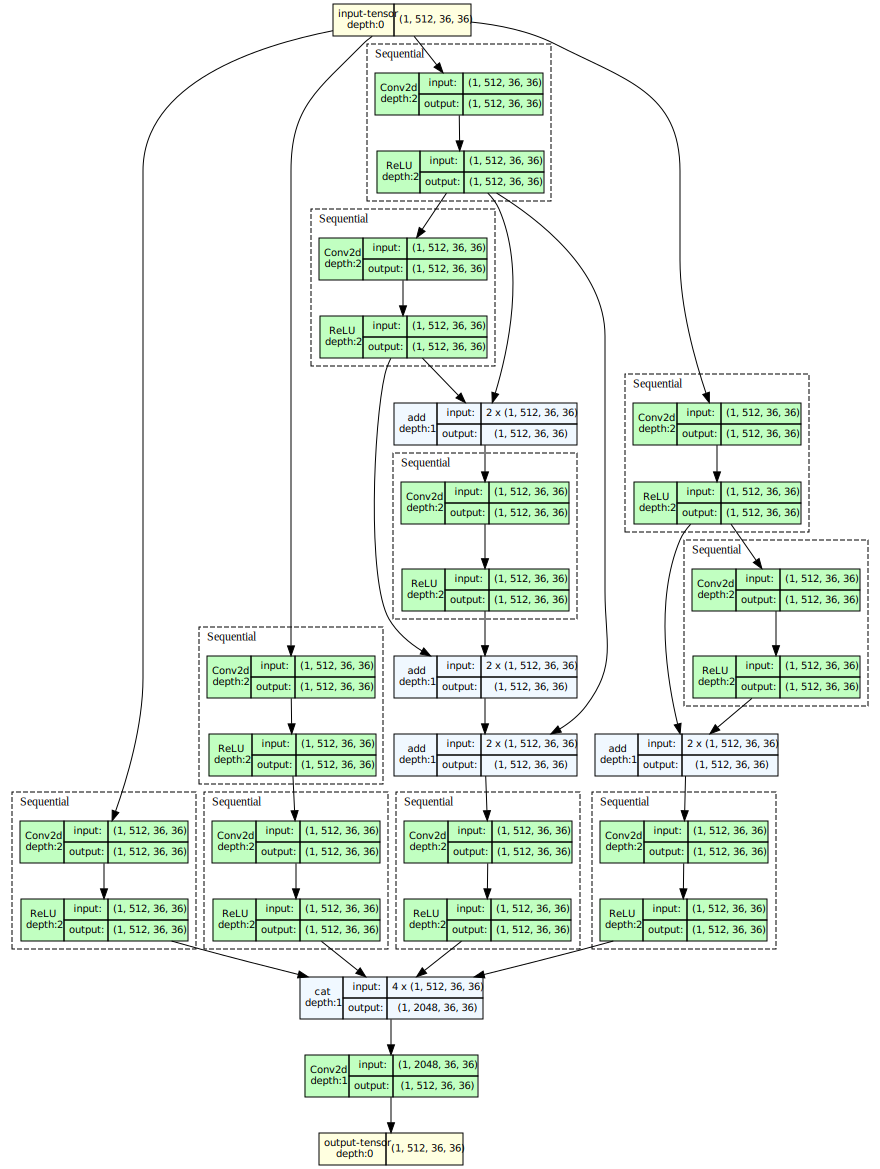

In [ ]:
pdc = PDCBlock(in_channels=512, out_channels=512)
pdc_graph = draw_graph(pdc, input_size=(1, 512, 36, 36), expand_nested=True)
pdc_graph.visual_graph


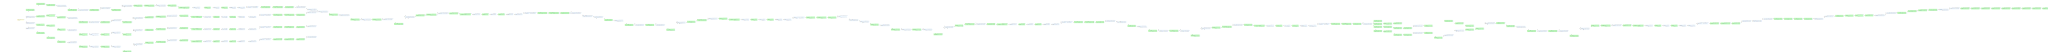

In [ ]:
from torchview import draw_graph


# Instantiate model
model = MRP_UNet(num_classes=2)

# Draw graph
viz = draw_graph(
    model,
    input_size=(1, 3, 288, 288),   # batch size 1, 3-channel image
    expand_nested=False,           # shows inner modules like Res2SEBlock
    graph_dir='LR',               # left-to-right layout
    save_graph=True,              # saves as .png
    filename='mrp_unet_architecture'  # output file name (default: 'model')
)

viz.visual_graph  # display in Jupyter Notebook or save as image


In [ ]:

res2se = Res2SEBlock(channels=256)
res2se_graph = draw_graph(
    res2se,
    input_size=(1, 256, 72, 72),
    expand_nested=True,
    save_graph=True,
    filename='res2se_block',
    directory='.',
    graph_dir='TB'
)


# Dataset

In [ ]:
train_img_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
train_mask_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth"


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  #  Needed for optimizer

from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm
from skimage import measure  #  For largest component postprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# training

In [ ]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = torch.argmax(pred, dim=1)  # [B, H, W]
    target = target.long()            # [B, H, W]

    intersection = ((pred == 1) & (target == 1)).float().sum((1, 2))
    union = (pred == 1).float().sum((1, 2)) + (target == 1).float().sum((1, 2))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean().item()

def jaccard_index(pred, target, smooth=1e-6):
    pred = torch.argmax(pred, dim=1)
    target = target.long()

    intersection = ((pred == 1) & (target == 1)).float().sum((1, 2))
    union = ((pred == 1) | (target == 1)).float().sum((1, 2))
    return ((intersection + smooth) / (union + smooth)).mean().item()

class ISIC2017SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))

        # Binarize mask: make sure values are 0 or 1
        mask = (mask > 0).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"].long()  # [H, W]

        return img, mask  # [3,H,W], [H,W]

    def __len__(self):
        return len(self.image_paths)
transform = A.Compose([
    A.Resize(288, 288),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
image_ids = sorted([f[:-4] for f in os.listdir(train_img_dir) if f.endswith(".jpg")])
image_paths = [os.path.join(train_img_dir, f"{i}.jpg") for i in image_ids]
mask_paths = [os.path.join(train_mask_dir, f"{i}_segmentation.png") for i in image_ids]

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_dataset = ISIC2017SegmentationDataset(train_imgs, train_masks, transform)
val_dataset = ISIC2017SegmentationDataset(val_imgs, val_masks, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, pin_memory=True)



In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)  # [B, 2, H, W]
        preds = probs[:, 1, :, :]             # foreground class
        targets = (targets == 1).float()      # [B, H, W]
        intersection = (preds * targets).sum(dim=(1, 2))
        union = preds.sum(dim=(1, 2)) + targets.sum(dim=(1, 2))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()  # we minimize (1 - Dice)


def train_model(model, train_loader, val_loader, num_epochs=100, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    ce_loss = nn.CrossEntropyLoss()
    dice_loss = DiceLoss()

    def combined_loss(logits, targets):
        return 0.5 * ce_loss(logits, targets) + 0.5 * dice_loss(logits, targets)

    best_dice = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # --- Validation ---
        model.eval()
        val_loss = 0
        dices, jaccards = [], []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = combined_loss(outputs, masks)
                val_loss += loss.item()
                dices.append(dice_coefficient(outputs, masks))
                jaccards.append(jaccard_index(outputs, masks))

        avg_dice = np.mean(dices)
        avg_jaccard = np.mean(jaccards)
        print(f"[Epoch {epoch+1}] Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f} | Dice: {avg_dice:.4f} | Jaccard: {avg_jaccard:.4f}")

        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), "best_model.pth")
            print(" Best model saved!")

        scheduler.step()


In [ ]:
model = MRP_UNet(num_classes=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model, train_loader, val_loader, num_epochs=100, device=device)


[Epoch 1/100] Training: 100%|██████████| 400/400 [03:07<00:00,  2.13it/s]


[Epoch 1] Train Loss: 0.3210 | Val Loss: 0.2492 | Dice: 0.7519 | Jaccard: 0.6571
 Best model saved!


[Epoch 2/100] Training: 100%|██████████| 400/400 [02:37<00:00,  2.54it/s]


[Epoch 2] Train Loss: 0.2116 | Val Loss: 0.1787 | Dice: 0.8403 | Jaccard: 0.7566
 Best model saved!


[Epoch 3/100] Training: 100%|██████████| 400/400 [02:37<00:00,  2.53it/s]


[Epoch 3] Train Loss: 0.1732 | Val Loss: 0.1702 | Dice: 0.8453 | Jaccard: 0.7574
 Best model saved!


[Epoch 4/100] Training: 100%|██████████| 400/400 [02:38<00:00,  2.53it/s]


[Epoch 4] Train Loss: 0.1560 | Val Loss: 0.1539 | Dice: 0.8530 | Jaccard: 0.7691
 Best model saved!


[Epoch 5/100] Training: 100%|██████████| 400/400 [02:22<00:00,  2.80it/s]


[Epoch 5] Train Loss: 0.1453 | Val Loss: 0.1868 | Dice: 0.8610 | Jaccard: 0.7807
 Best model saved!


[Epoch 6/100] Training: 100%|██████████| 400/400 [02:31<00:00,  2.65it/s]


[Epoch 6] Train Loss: 0.1428 | Val Loss: 0.1323 | Dice: 0.8703 | Jaccard: 0.7923
 Best model saved!


[Epoch 7/100] Training: 100%|██████████| 400/400 [02:32<00:00,  2.63it/s]


[Epoch 7] Train Loss: 0.1329 | Val Loss: 0.1228 | Dice: 0.8797 | Jaccard: 0.8056
 Best model saved!


[Epoch 8/100] Training: 100%|██████████| 400/400 [02:32<00:00,  2.63it/s]


[Epoch 8] Train Loss: 0.1300 | Val Loss: 0.1254 | Dice: 0.8835 | Jaccard: 0.8096
 Best model saved!


[Epoch 9/100] Training: 100%|██████████| 400/400 [02:24<00:00,  2.77it/s]


[Epoch 9] Train Loss: 0.1175 | Val Loss: 0.1598 | Dice: 0.8662 | Jaccard: 0.7837


[Epoch 10/100] Training: 100%|██████████| 400/400 [02:32<00:00,  2.62it/s]


[Epoch 10] Train Loss: 0.1113 | Val Loss: 0.1229 | Dice: 0.8828 | Jaccard: 0.8086


[Epoch 11/100] Training: 100%|██████████| 400/400 [02:36<00:00,  2.56it/s]


[Epoch 11] Train Loss: 0.1068 | Val Loss: 0.1173 | Dice: 0.8857 | Jaccard: 0.8157
 Best model saved!


[Epoch 12/100] Training: 100%|██████████| 400/400 [02:37<00:00,  2.54it/s]


[Epoch 12] Train Loss: 0.1044 | Val Loss: 0.1279 | Dice: 0.8801 | Jaccard: 0.8059


[Epoch 13/100] Training: 100%|██████████| 400/400 [02:36<00:00,  2.55it/s]


[Epoch 13] Train Loss: 0.1007 | Val Loss: 0.1105 | Dice: 0.8912 | Jaccard: 0.8216
 Best model saved!


[Epoch 14/100] Training: 100%|██████████| 400/400 [02:36<00:00,  2.55it/s]


[Epoch 14] Train Loss: 0.0960 | Val Loss: 0.1208 | Dice: 0.8826 | Jaccard: 0.8094


[Epoch 15/100] Training: 100%|██████████| 400/400 [02:37<00:00,  2.54it/s]


[Epoch 15] Train Loss: 0.0900 | Val Loss: 0.1210 | Dice: 0.8928 | Jaccard: 0.8236
 Best model saved!


[Epoch 16/100] Training: 100%|██████████| 400/400 [02:28<00:00,  2.70it/s]


[Epoch 16] Train Loss: 0.0877 | Val Loss: 0.1335 | Dice: 0.8842 | Jaccard: 0.8129


[Epoch 17/100] Training: 100%|██████████| 400/400 [02:38<00:00,  2.53it/s]


[Epoch 17] Train Loss: 0.0835 | Val Loss: 0.1423 | Dice: 0.8690 | Jaccard: 0.7927


[Epoch 18/100] Training: 100%|██████████| 400/400 [02:36<00:00,  2.56it/s]


[Epoch 18] Train Loss: 0.0819 | Val Loss: 0.1119 | Dice: 0.8925 | Jaccard: 0.8240


[Epoch 19/100] Training: 100%|██████████| 400/400 [02:22<00:00,  2.81it/s]


[Epoch 19] Train Loss: 0.0791 | Val Loss: 0.1210 | Dice: 0.8888 | Jaccard: 0.8187


[Epoch 20/100] Training: 100%|██████████| 400/400 [02:28<00:00,  2.69it/s]


[Epoch 20] Train Loss: 0.0743 | Val Loss: 0.1207 | Dice: 0.8896 | Jaccard: 0.8218


[Epoch 21/100] Training: 100%|██████████| 400/400 [02:32<00:00,  2.62it/s]


[Epoch 21] Train Loss: 0.0695 | Val Loss: 0.1201 | Dice: 0.8898 | Jaccard: 0.8188


[Epoch 22/100] Training: 100%|██████████| 400/400 [02:36<00:00,  2.55it/s]


[Epoch 22] Train Loss: 0.0659 | Val Loss: 0.1133 | Dice: 0.8910 | Jaccard: 0.8222


[Epoch 23/100] Training: 100%|██████████| 400/400 [02:34<00:00,  2.59it/s]


[Epoch 23] Train Loss: 0.0641 | Val Loss: 0.1337 | Dice: 0.8854 | Jaccard: 0.8138


[Epoch 24/100] Training: 100%|██████████| 400/400 [02:36<00:00,  2.55it/s]


[Epoch 24] Train Loss: 0.0617 | Val Loss: 0.1250 | Dice: 0.8912 | Jaccard: 0.8233


[Epoch 25/100] Training: 100%|██████████| 400/400 [02:36<00:00,  2.55it/s]


[Epoch 25] Train Loss: 0.0564 | Val Loss: 0.1346 | Dice: 0.8923 | Jaccard: 0.8246


[Epoch 26/100] Training: 100%|██████████| 400/400 [02:37<00:00,  2.54it/s]


[Epoch 26] Train Loss: 0.0552 | Val Loss: 0.1355 | Dice: 0.8903 | Jaccard: 0.8215


[Epoch 27/100] Training: 100%|██████████| 400/400 [02:32<00:00,  2.62it/s]


[Epoch 27] Train Loss: 0.0528 | Val Loss: 0.1295 | Dice: 0.8897 | Jaccard: 0.8203


[Epoch 28/100] Training: 100%|██████████| 400/400 [02:29<00:00,  2.68it/s]


[Epoch 28] Train Loss: 0.0504 | Val Loss: 0.1321 | Dice: 0.8906 | Jaccard: 0.8195


[Epoch 29/100] Training: 100%|██████████| 400/400 [02:26<00:00,  2.73it/s]


[Epoch 29] Train Loss: 0.0464 | Val Loss: 0.1486 | Dice: 0.8861 | Jaccard: 0.8177


[Epoch 30/100] Training: 100%|██████████| 400/400 [02:29<00:00,  2.68it/s]


[Epoch 30] Train Loss: 0.0451 | Val Loss: 0.1445 | Dice: 0.8866 | Jaccard: 0.8174


[Epoch 31/100] Training: 100%|██████████| 400/400 [02:38<00:00,  2.53it/s]


[Epoch 31] Train Loss: 0.0416 | Val Loss: 0.1339 | Dice: 0.8967 | Jaccard: 0.8281
 Best model saved!


[Epoch 32/100] Training: 100%|██████████| 400/400 [02:22<00:00,  2.80it/s]


[Epoch 32] Train Loss: 0.0388 | Val Loss: 0.1346 | Dice: 0.8958 | Jaccard: 0.8263


[Epoch 33/100] Training: 100%|██████████| 400/400 [02:21<00:00,  2.83it/s]


[Epoch 33] Train Loss: 0.0378 | Val Loss: 0.1383 | Dice: 0.8968 | Jaccard: 0.8285
 Best model saved!


[Epoch 34/100] Training: 100%|██████████| 400/400 [02:20<00:00,  2.84it/s]


[Epoch 34] Train Loss: 0.0356 | Val Loss: 0.1366 | Dice: 0.8940 | Jaccard: 0.8242


[Epoch 35/100] Training: 100%|██████████| 400/400 [02:34<00:00,  2.60it/s]


[Epoch 35] Train Loss: 0.0345 | Val Loss: 0.1453 | Dice: 0.8953 | Jaccard: 0.8257


[Epoch 36/100] Training: 100%|██████████| 400/400 [02:28<00:00,  2.69it/s]


[Epoch 36] Train Loss: 0.0325 | Val Loss: 0.1549 | Dice: 0.8937 | Jaccard: 0.8255


[Epoch 37/100] Training: 100%|██████████| 400/400 [02:28<00:00,  2.69it/s]


[Epoch 37] Train Loss: 0.0318 | Val Loss: 0.1677 | Dice: 0.8876 | Jaccard: 0.8192


[Epoch 38/100] Training: 100%|██████████| 400/400 [02:39<00:00,  2.51it/s]


[Epoch 38] Train Loss: 0.0295 | Val Loss: 0.1445 | Dice: 0.8975 | Jaccard: 0.8294
 Best model saved!


[Epoch 39/100] Training: 100%|██████████| 400/400 [02:21<00:00,  2.82it/s]


[Epoch 39] Train Loss: 0.0281 | Val Loss: 0.1643 | Dice: 0.8940 | Jaccard: 0.8254


[Epoch 40/100] Training: 100%|██████████| 400/400 [02:37<00:00,  2.55it/s]


[Epoch 40] Train Loss: 0.0276 | Val Loss: 0.1417 | Dice: 0.8950 | Jaccard: 0.8252


[Epoch 41/100] Training: 100%|██████████| 400/400 [02:45<00:00,  2.42it/s]


[Epoch 41] Train Loss: 0.0263 | Val Loss: 0.1471 | Dice: 0.8988 | Jaccard: 0.8301
 Best model saved!


[Epoch 42/100] Training: 100%|██████████| 400/400 [02:30<00:00,  2.65it/s]


[Epoch 42] Train Loss: 0.0254 | Val Loss: 0.1522 | Dice: 0.8978 | Jaccard: 0.8286


[Epoch 43/100] Training: 100%|██████████| 400/400 [02:41<00:00,  2.47it/s]


[Epoch 43] Train Loss: 0.0248 | Val Loss: 0.1577 | Dice: 0.8961 | Jaccard: 0.8277


[Epoch 44/100] Training: 100%|██████████| 400/400 [02:51<00:00,  2.33it/s]


[Epoch 44] Train Loss: 0.0241 | Val Loss: 0.1724 | Dice: 0.8955 | Jaccard: 0.8274


[Epoch 45/100] Training: 100%|██████████| 400/400 [02:23<00:00,  2.79it/s]


[Epoch 45] Train Loss: 0.0230 | Val Loss: 0.1608 | Dice: 0.8970 | Jaccard: 0.8281


[Epoch 46/100] Training: 100%|██████████| 400/400 [02:30<00:00,  2.65it/s]


[Epoch 46] Train Loss: 0.0226 | Val Loss: 0.1491 | Dice: 0.9003 | Jaccard: 0.8328
 Best model saved!


[Epoch 47/100] Training: 100%|██████████| 400/400 [02:34<00:00,  2.59it/s]


[Epoch 47] Train Loss: 0.0219 | Val Loss: 0.1549 | Dice: 0.8990 | Jaccard: 0.8320


[Epoch 48/100] Training: 100%|██████████| 400/400 [02:31<00:00,  2.64it/s]


[Epoch 48] Train Loss: 0.0215 | Val Loss: 0.1565 | Dice: 0.8990 | Jaccard: 0.8313


[Epoch 49/100] Training: 100%|██████████| 400/400 [02:28<00:00,  2.69it/s]


[Epoch 49] Train Loss: 0.0207 | Val Loss: 0.1560 | Dice: 0.9005 | Jaccard: 0.8333
 Best model saved!


[Epoch 50/100] Training: 100%|██████████| 400/400 [02:24<00:00,  2.77it/s]


[Epoch 50] Train Loss: 0.0204 | Val Loss: 0.1605 | Dice: 0.8989 | Jaccard: 0.8304


[Epoch 51/100] Training: 100%|██████████| 400/400 [02:23<00:00,  2.78it/s]


[Epoch 51] Train Loss: 0.0200 | Val Loss: 0.1610 | Dice: 0.8986 | Jaccard: 0.8305


[Epoch 52/100] Training: 100%|██████████| 400/400 [02:32<00:00,  2.62it/s]


[Epoch 52] Train Loss: 0.0193 | Val Loss: 0.1756 | Dice: 0.8969 | Jaccard: 0.8288


[Epoch 53/100] Training: 100%|██████████| 400/400 [02:25<00:00,  2.75it/s]


[Epoch 53] Train Loss: 0.0189 | Val Loss: 0.1588 | Dice: 0.9003 | Jaccard: 0.8331


[Epoch 54/100] Training: 100%|██████████| 400/400 [02:30<00:00,  2.65it/s]


[Epoch 54] Train Loss: 0.0184 | Val Loss: 0.1567 | Dice: 0.9008 | Jaccard: 0.8338
 Best model saved!


[Epoch 55/100] Training: 100%|██████████| 400/400 [02:24<00:00,  2.76it/s]


[Epoch 55] Train Loss: 0.0180 | Val Loss: 0.1650 | Dice: 0.9004 | Jaccard: 0.8333


[Epoch 56/100] Training: 100%|██████████| 400/400 [02:32<00:00,  2.62it/s]


[Epoch 56] Train Loss: 0.0177 | Val Loss: 0.1705 | Dice: 0.8988 | Jaccard: 0.8308


[Epoch 57/100] Training: 100%|██████████| 400/400 [02:31<00:00,  2.64it/s]


[Epoch 57] Train Loss: 0.0172 | Val Loss: 0.1736 | Dice: 0.8980 | Jaccard: 0.8305


[Epoch 58/100] Training: 100%|██████████| 400/400 [02:25<00:00,  2.76it/s]


[Epoch 58] Train Loss: 0.0170 | Val Loss: 0.1701 | Dice: 0.9009 | Jaccard: 0.8338
 Best model saved!


[Epoch 59/100] Training: 100%|██████████| 400/400 [02:25<00:00,  2.75it/s]


[Epoch 59] Train Loss: 0.0167 | Val Loss: 0.1662 | Dice: 0.9012 | Jaccard: 0.8341
 Best model saved!


[Epoch 60/100] Training: 100%|██████████| 400/400 [02:28<00:00,  2.70it/s]


[Epoch 60] Train Loss: 0.0164 | Val Loss: 0.1803 | Dice: 0.8996 | Jaccard: 0.8325


[Epoch 61/100] Training: 100%|██████████| 400/400 [02:20<00:00,  2.85it/s]


[Epoch 61] Train Loss: 0.0159 | Val Loss: 0.1655 | Dice: 0.9008 | Jaccard: 0.8338


[Epoch 62/100] Training: 100%|██████████| 400/400 [02:39<00:00,  2.51it/s]


[Epoch 62] Train Loss: 0.0157 | Val Loss: 0.1694 | Dice: 0.8992 | Jaccard: 0.8317


[Epoch 63/100] Training: 100%|██████████| 400/400 [02:08<00:00,  3.12it/s]


[Epoch 63] Train Loss: 0.0154 | Val Loss: 0.1780 | Dice: 0.8990 | Jaccard: 0.8316


[Epoch 64/100] Training: 100%|██████████| 400/400 [02:20<00:00,  2.84it/s]


[Epoch 64] Train Loss: 0.0150 | Val Loss: 0.1697 | Dice: 0.9006 | Jaccard: 0.8331


[Epoch 65/100] Training: 100%|██████████| 400/400 [02:21<00:00,  2.83it/s]


[Epoch 65] Train Loss: 0.0149 | Val Loss: 0.1711 | Dice: 0.9014 | Jaccard: 0.8338
 Best model saved!


[Epoch 66/100] Training: 100%|██████████| 400/400 [02:32<00:00,  2.63it/s]


[Epoch 66] Train Loss: 0.0146 | Val Loss: 0.1705 | Dice: 0.9016 | Jaccard: 0.8345
 Best model saved!


[Epoch 67/100] Training: 100%|██████████| 400/400 [02:31<00:00,  2.64it/s]


[Epoch 67] Train Loss: 0.0142 | Val Loss: 0.1768 | Dice: 0.8999 | Jaccard: 0.8328


[Epoch 68/100] Training: 100%|██████████| 400/400 [02:26<00:00,  2.73it/s]


[Epoch 68] Train Loss: 0.0141 | Val Loss: 0.1771 | Dice: 0.9008 | Jaccard: 0.8338


[Epoch 69/100] Training: 100%|██████████| 400/400 [02:35<00:00,  2.58it/s]


[Epoch 69] Train Loss: 0.0139 | Val Loss: 0.1798 | Dice: 0.9007 | Jaccard: 0.8335


[Epoch 70/100] Training: 100%|██████████| 400/400 [02:29<00:00,  2.68it/s]


[Epoch 70] Train Loss: 0.0138 | Val Loss: 0.1729 | Dice: 0.9019 | Jaccard: 0.8350
 Best model saved!


[Epoch 71/100] Training: 100%|██████████| 400/400 [02:34<00:00,  2.60it/s]


[Epoch 71] Train Loss: 0.0134 | Val Loss: 0.1806 | Dice: 0.9020 | Jaccard: 0.8348
 Best model saved!


[Epoch 72/100] Training: 100%|██████████| 400/400 [02:21<00:00,  2.83it/s]


[Epoch 72] Train Loss: 0.0132 | Val Loss: 0.1869 | Dice: 0.9000 | Jaccard: 0.8323


[Epoch 73/100] Training: 100%|██████████| 400/400 [02:31<00:00,  2.63it/s]


[Epoch 73] Train Loss: 0.0130 | Val Loss: 0.1870 | Dice: 0.9001 | Jaccard: 0.8331


[Epoch 74/100] Training: 100%|██████████| 400/400 [02:30<00:00,  2.66it/s]


[Epoch 74] Train Loss: 0.0128 | Val Loss: 0.1834 | Dice: 0.9007 | Jaccard: 0.8338


[Epoch 75/100] Training: 100%|██████████| 400/400 [02:31<00:00,  2.65it/s]


[Epoch 75] Train Loss: 0.0127 | Val Loss: 0.1805 | Dice: 0.9004 | Jaccard: 0.8333


[Epoch 76/100] Training: 100%|██████████| 400/400 [02:24<00:00,  2.76it/s]


[Epoch 76] Train Loss: 0.0125 | Val Loss: 0.1835 | Dice: 0.9004 | Jaccard: 0.8332


[Epoch 77/100] Training: 100%|██████████| 400/400 [02:32<00:00,  2.63it/s]


[Epoch 77] Train Loss: 0.0124 | Val Loss: 0.1828 | Dice: 0.9012 | Jaccard: 0.8341


[Epoch 78/100] Training: 100%|██████████| 400/400 [02:24<00:00,  2.77it/s]


[Epoch 78] Train Loss: 0.0121 | Val Loss: 0.1878 | Dice: 0.9010 | Jaccard: 0.8340


[Epoch 79/100] Training: 100%|██████████| 400/400 [02:39<00:00,  2.52it/s]


[Epoch 79] Train Loss: 0.0121 | Val Loss: 0.1895 | Dice: 0.9007 | Jaccard: 0.8335


[Epoch 80/100] Training: 100%|██████████| 400/400 [02:32<00:00,  2.62it/s]


[Epoch 80] Train Loss: 0.0119 | Val Loss: 0.1935 | Dice: 0.9007 | Jaccard: 0.8337


[Epoch 81/100] Training: 100%|██████████| 400/400 [02:14<00:00,  2.96it/s]


[Epoch 81] Train Loss: 0.0118 | Val Loss: 0.1864 | Dice: 0.9016 | Jaccard: 0.8345


[Epoch 82/100] Training: 100%|██████████| 400/400 [02:36<00:00,  2.55it/s]


[Epoch 82] Train Loss: 0.0118 | Val Loss: 0.1892 | Dice: 0.9008 | Jaccard: 0.8336


[Epoch 83/100] Training: 100%|██████████| 400/400 [02:16<00:00,  2.92it/s]


[Epoch 83] Train Loss: 0.0116 | Val Loss: 0.1924 | Dice: 0.9002 | Jaccard: 0.8332


[Epoch 84/100] Training: 100%|██████████| 400/400 [02:28<00:00,  2.70it/s]


[Epoch 84] Train Loss: 0.0115 | Val Loss: 0.1935 | Dice: 0.9012 | Jaccard: 0.8342


[Epoch 85/100] Training: 100%|██████████| 400/400 [02:27<00:00,  2.71it/s]


[Epoch 85] Train Loss: 0.0114 | Val Loss: 0.1936 | Dice: 0.9008 | Jaccard: 0.8338


[Epoch 86/100] Training: 100%|██████████| 400/400 [02:27<00:00,  2.70it/s]


[Epoch 86] Train Loss: 0.0113 | Val Loss: 0.1957 | Dice: 0.9010 | Jaccard: 0.8341


[Epoch 88/100] Training: 100%|██████████| 400/400 [02:33<00:00,  2.61it/s]


[Epoch 88] Train Loss: 0.0112 | Val Loss: 0.1926 | Dice: 0.9007 | Jaccard: 0.8337


[Epoch 89/100] Training: 100%|██████████| 400/400 [02:33<00:00,  2.61it/s]


[Epoch 89] Train Loss: 0.0111 | Val Loss: 0.1945 | Dice: 0.9005 | Jaccard: 0.8334


[Epoch 90/100] Training: 100%|██████████| 400/400 [02:33<00:00,  2.61it/s]


[Epoch 90] Train Loss: 0.0110 | Val Loss: 0.1949 | Dice: 0.9003 | Jaccard: 0.8331


[Epoch 91/100] Training: 100%|██████████| 400/400 [02:11<00:00,  3.05it/s]


[Epoch 91] Train Loss: 0.0110 | Val Loss: 0.1918 | Dice: 0.9005 | Jaccard: 0.8335


[Epoch 92/100] Training: 100%|██████████| 400/400 [02:27<00:00,  2.71it/s]


[Epoch 92] Train Loss: 0.0109 | Val Loss: 0.1938 | Dice: 0.9006 | Jaccard: 0.8334


[Epoch 93/100] Training: 100%|██████████| 400/400 [02:31<00:00,  2.64it/s]


[Epoch 93] Train Loss: 0.0109 | Val Loss: 0.1959 | Dice: 0.9001 | Jaccard: 0.8330


[Epoch 94/100] Training: 100%|██████████| 400/400 [02:34<00:00,  2.59it/s]


[Epoch 94] Train Loss: 0.0109 | Val Loss: 0.1932 | Dice: 0.9005 | Jaccard: 0.8335


[Epoch 95/100] Training: 100%|██████████| 400/400 [02:37<00:00,  2.55it/s]


[Epoch 95] Train Loss: 0.0108 | Val Loss: 0.1960 | Dice: 0.9001 | Jaccard: 0.8330


[Epoch 96/100] Training: 100%|██████████| 400/400 [02:28<00:00,  2.68it/s]


[Epoch 96] Train Loss: 0.0108 | Val Loss: 0.1933 | Dice: 0.9002 | Jaccard: 0.8329


[Epoch 97/100] Training: 100%|██████████| 400/400 [02:29<00:00,  2.68it/s]


[Epoch 97] Train Loss: 0.0108 | Val Loss: 0.1932 | Dice: 0.9001 | Jaccard: 0.8330


[Epoch 98/100] Training: 100%|██████████| 400/400 [02:33<00:00,  2.60it/s]


[Epoch 98] Train Loss: 0.0108 | Val Loss: 0.1964 | Dice: 0.8997 | Jaccard: 0.8326


[Epoch 99/100] Training: 100%|██████████| 400/400 [02:23<00:00,  2.78it/s]


[Epoch 99] Train Loss: 0.0107 | Val Loss: 0.2003 | Dice: 0.9001 | Jaccard: 0.8330


[Epoch 100/100] Training: 100%|██████████| 400/400 [02:30<00:00,  2.66it/s]


[Epoch 100] Train Loss: 0.0107 | Val Loss: 0.2002 | Dice: 0.9000 | Jaccard: 0.8327


# evaluation

In [ ]:
model = MRP_UNet(num_classes=2)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
model.to("cuda")


MRP_UNet(
  (mif): MIFModule(
    (conv288): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv144): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv72): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv36): Sequential(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (enc1): Res2SEBlock(
    (res2): Res2Block(
      (conv1x1_in): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (conv1x1_out): Conv2d(64, 64, kernel_size=

Evaluation

In [ ]:
import cv2
import numpy as np

def post_process_mask(mask):
    # mask: [H, W], values 0 or 1
    mask = mask.astype(np.uint8) * 255

    # Remove small blobs
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Convert back to binary
    return (mask > 127).astype(np.uint8)


  0%|          | 0/200 [00:00<?, ?it/s]

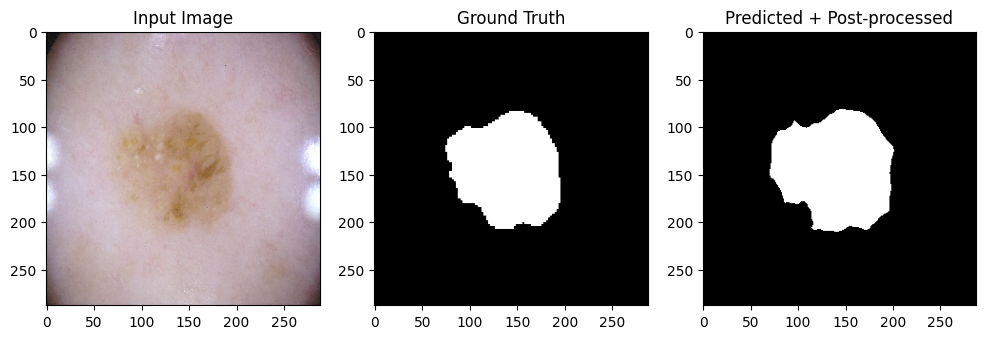

  0%|          | 1/200 [00:00<02:40,  1.24it/s]

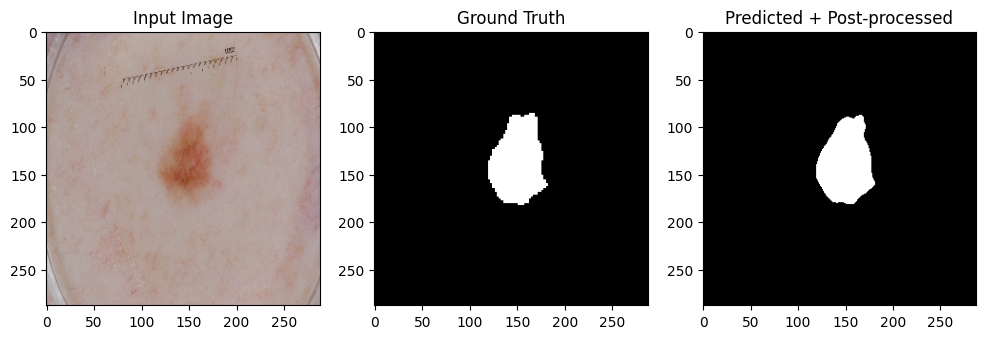

  1%|          | 2/200 [00:01<02:03,  1.60it/s]

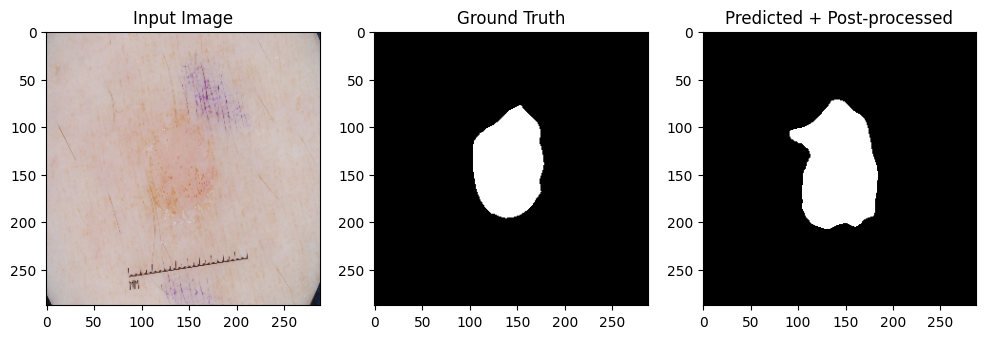

100%|██████████| 200/200 [00:39<00:00,  5.10it/s]


Avg Dice: 0.9020
Avg Jaccard: 0.8348


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np

dice_scores = []
jaccard_scores = []

model.eval()  # Ensure model is in eval mode

with torch.no_grad():
    for idx, (image, mask) in enumerate(tqdm(val_loader)):
        image = image.to("cuda")  # (B, 3, H, W)
        mask = mask.to("cuda")    # (B, 1, H, W) or (B, H, W)

        output = model(image)     # (B, C, H, W)

        # If multi-class, convert prediction to class map
        if output.shape[1] > 1:
            pred = torch.argmax(output, dim=1)  # (B, H, W)
        else:
            pred = (output > 0.5).long().squeeze(1)  # Binary case

        pred = pred.cpu().numpy()
        mask = mask.squeeze(1).cpu().numpy()

        # Loop over batch (in case batch size > 1)
        for b in range(image.size(0)):
            pred_post = post_process_mask(pred[b])  # Apply your post-processing

            gt = mask[b]
            intersection = np.logical_and(pred_post == 1, gt == 1).sum()
            union = np.logical_or(pred_post == 1, gt == 1).sum()
            dice = (2 * intersection) / (np.sum(pred_post) + np.sum(gt) + 1e-6)
            jaccard = intersection / (union + 1e-6)

            dice_scores.append(dice)
            jaccard_scores.append(jaccard)

            # Optional visualization (only first few samples)
            if idx < 3 and b == 0:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                img_np = image[b].permute(1, 2, 0).cpu().numpy()
                img_np = img_np * 0.5 + 0.5  # De-normalize if needed
                plt.imshow(np.clip(img_np, 0, 1))
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(gt, cmap='gray')
                plt.title("Ground Truth")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_post, cmap='gray')
                plt.title("Predicted + Post-processed")
                plt.show()

# Report average metrics
print(f"\nAvg Dice: {np.mean(dice_scores):.4f}")
print(f"Avg Jaccard: {np.mean(jaccard_scores):.4f}")


with TTA

  0%|          | 0/200 [00:00<?, ?it/s]

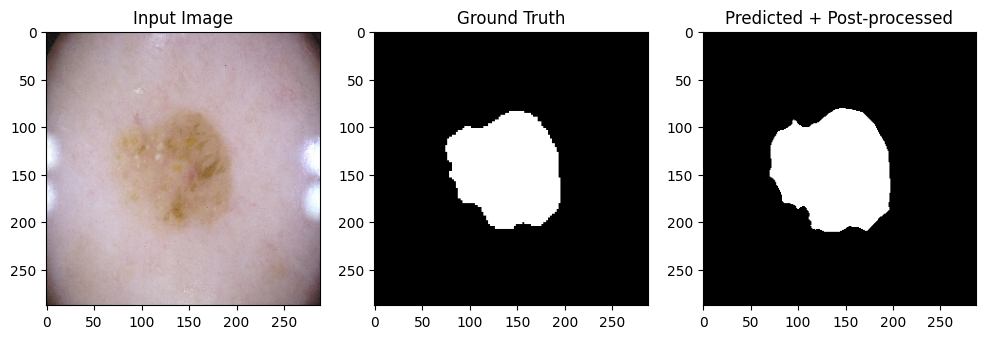

  0%|          | 1/200 [00:01<04:24,  1.33s/it]

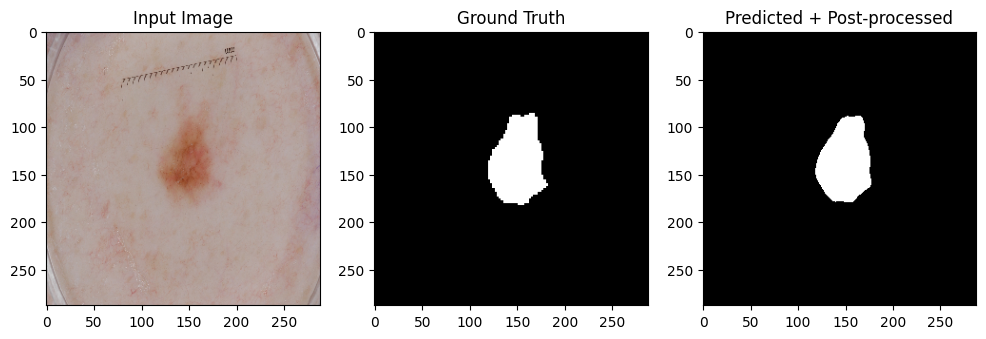

  1%|          | 2/200 [00:02<03:44,  1.13s/it]

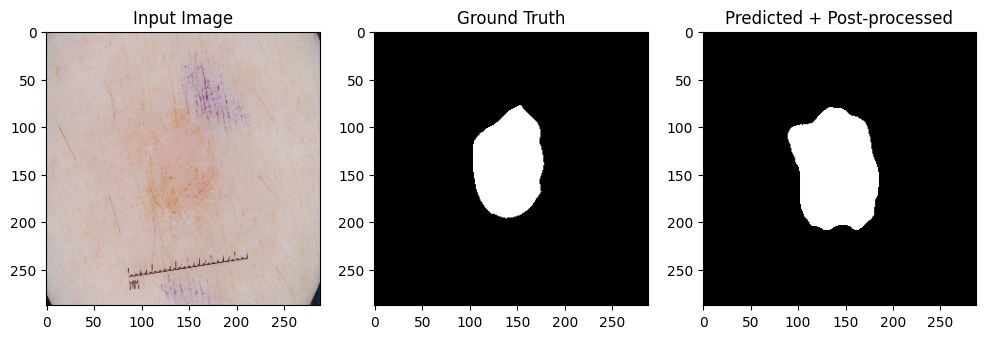

100%|██████████| 200/200 [00:55<00:00,  3.59it/s]


Avg Dice: 0.9041
Avg Jaccard: 0.8390


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision.transforms.functional as TF

dice_scores = []
jaccard_scores = []

model.eval()

def apply_tta(model, image):
    """Performs Test-Time Augmentation (horizontal/vertical flips) and returns averaged prediction."""
    augmented_images = [
        image,
        TF.hflip(image),
        TF.vflip(image),
        TF.vflip(TF.hflip(image))
    ]

    preds = []
    for aug_img in augmented_images:
        aug_img = aug_img.unsqueeze(0).to("cuda")  # Add batch dim
        output = model(aug_img)
        if output.shape[1] > 1:
            output = torch.softmax(output, dim=1)
        else:
            output = torch.sigmoid(output)
        preds.append(output.cpu())

    # Reverse transforms
    preds[1] = TF.hflip(preds[1].squeeze(0))
    preds[2] = TF.vflip(preds[2].squeeze(0))
    preds[3] = TF.vflip(TF.hflip(preds[3].squeeze(0)))

    stacked = torch.stack([preds[0].squeeze(0), preds[1], preds[2], preds[3]])  # (4, C, H, W)
    avg_pred = stacked.mean(dim=0, keepdim=True)  # (1, C, H, W)
    return avg_pred

with torch.no_grad():
    for idx, (image, mask) in enumerate(tqdm(val_loader)):
        image = image.to("cuda")  # (B, 3, H, W)
        mask = mask.to("cuda")    # (B, 1, H, W) or (B, H, W)

        for b in range(image.size(0)):
            img = image[b]
            gt = mask[b].squeeze().cpu().numpy()

            # TTA prediction
            output = apply_tta(model, img)  # (1, C, H, W)

            # Convert to label
            if output.shape[1] > 1:
                pred = torch.argmax(output, dim=1).squeeze(0).numpy()
            else:
                pred = (output.squeeze(0).squeeze(0) > 0.5).long().numpy()

            # Post-process
            pred_post = post_process_mask(pred)

            # Dice + Jaccard
            intersection = np.logical_and(pred_post == 1, gt == 1).sum()
            union = np.logical_or(pred_post == 1, gt == 1).sum()
            dice = (2 * intersection) / (np.sum(pred_post) + np.sum(gt) + 1e-6)
            jaccard = intersection / (union + 1e-6)

            dice_scores.append(dice)
            jaccard_scores.append(jaccard)

            # Visualize few
            if idx < 3 and b == 0:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                img_np = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
                plt.imshow(np.clip(img_np, 0, 1))
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(gt, cmap='gray')
                plt.title("Ground Truth")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_post, cmap='gray')
                plt.title("Predicted + Post-processed")
                plt.show()

# Final metrics
print(f"\nAvg Dice: {np.mean(dice_scores):.4f}")
print(f"Avg Jaccard: {np.mean(jaccard_scores):.4f}")
